<a href="https://colab.research.google.com/github/DiegoAristizabal15/Python-DataScientist/blob/main/VisualizacionEjemploClase5CursoLaboratoriodeDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualización

La idea de esta notebook es recorrer algunas librerías de visualización de datos, analizando pros y contras de cada una, a partir de trabajar con una de las bases de datos ya vistas

In [ ]:
from google.colab import drive # La usamos para montar nuestra unidad de Google Drive


import pandas as pd # La usamos para manejar la base de datos (y también graficar) https://pandas.pydata.org/docs/

import matplotlib.pylab as plt # Herramienta principal de visualización https://matplotlib.org/stable/contents.html
import matplotlib.dates as mdates # Dentro de matplotlib, tenemos una herramienta para manejo de fechas 
import seaborn as sbn # Herramienta complementaria de visualización https://seaborn.pydata.org/


from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets # Podemos ganar interactividad en la misma notebook https://ipywidgets.readthedocs.io/en/latest/

import plotly.express as px # Generamos un html dinámico, compartible, sin necesidad de correr procesos por detrás https://plotly.com/python/

import numpy as np # Siempre resulta que la usamos
from wordcloud import WordCloud # Lo usamos para las nubes de palabras

## Importamos datos
Como hemos hecho en notebooks anteriores, traemos algunas de las bases de datos con las que estamos trabajando.

En este caso, traemos la relativa al proceso de vacunación y su percepción.

In [ ]:
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/vacunas_safe.csv' # Definimos la ubicación + nombre de archivo en cuestión

d_1 = pd.read_csv(filename) # Levantamos el archivo a través de pandas. Ahora, d_1 es un Data Frame


In [ ]:
"""
Un poco de procesamiento sobre la fecha. La quiero usar y previamente chequié que había un par de datos con la fecha alterada
Básicamente, aparecen dos problemas con las fechas:
  - En algunos casos, aparece un "," en el medio...
  - En otros casos, el mes aparece antes que el día. No entiendo por qué, tal vez gente respondiendo desde otros países o lo que sea
Detecté cuáles eran previamente y por eso, el arreglo lo vamos a hacer sobre aquellos índices malditos... (lo segundo, lo de las comas se lo paso a todas por las dudas)
"""
def cambio_fecha(f):
  """
  Esta función arregla aquellos registros que tenían formato distinto de fecha
  """
  f = f.split('/')
  return '/'.join([f[1],f[0],f[2]])

d_1.loc[[3575, 4043, 2130, 1590, 1439, 1121, 1073, 1008,  929,  917,  753, 579,  500,  548,  400,  123],
        'timestamp'] = d_1.loc[[3575, 4043, 2130, 1590, 1439, 1121, 1073, 1008,  929,  917,  753, 579,  500,  548,  400,  123],
                               'timestamp'].apply(cambio_fecha) # Aplico la función previamente creada para arreglar aquellas fechas mal formateadas

d_1['timestamp'] = d_1['timestamp'].apply(lambda x : pd.to_datetime(x.replace(',',''), format = '%d/%m/%Y %H:%M:%S')) # Llevo a datetime la columna de fechas ya arreglada                               

# Matplotlib


Matplotlib es uno de los paquetes fundamentales del universo python en lo que respecta a análisis de datos. Si bien tenemos que darnos maña y esforzarnos por customizar las figuras, muchas otras librerías corren matplotlib por detrás, es decir, se basan en ella. Por ejemplo, pandas utiliza esta librería.

Si bien hay muchas formas de generar figuras utilizando matplotlib, creo que está bueno acostumbrarse a usar la siguiente estructura, para poder tener más control sobre la misma:

```
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = ...)
```
Lo que estamos logrando con esto es generar una figura, que tendrá un sólo gráfico (row = 1, col = 1). Pero no sólo eso, sino que estamos generando por separado el objeto figura del objeto axis (ejes).

Dentro de algunos beneficios de hacerlo así, es que depués podemos espeficicar métodos para cada objeto, de forma diferenciada, así también como usar el objeto "ax" para ubicar futuros gráficos.


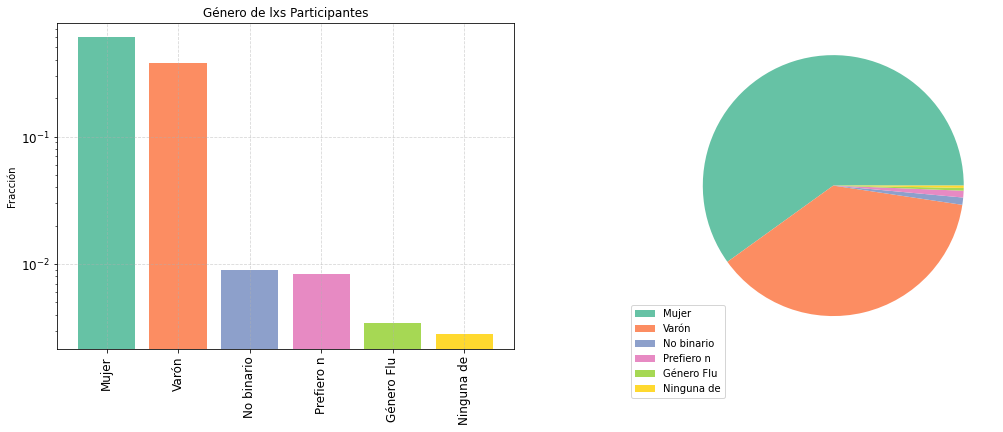

In [ ]:
dic_generos = {1 : 'Mujer', 2 : 'Varón', 3 : 'No binario', 4 : 'Género Fluido', 5 : 'Ninguna de las opciones me identifica', 6 : 'Prefiero no decirlo'} # Esto lo saco de uno de los diccionarios que indican qué significa cada número
generos = d_1['0_genero'].value_counts()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
axs[0].grid('on', linestyle = 'dashed', alpha = 0.5)
axs[0].set_title('Género de lxs Participantes')
axs[0].set_ylabel('Fracción')
axs[0].bar(x = [i for i in range(len(generos))], # Definimos la ubicación de las barras a lo largo del eje horizontal
           height = generos.values  / generos.values.sum(), # Definimos la altura de las barras
           color = plt.get_cmap('Set2').colors
           )
axs[0].set_xticks([i for i in range(len(generos))])
axs[0].set_xticklabels([dic_generos[g][:10] for g in generos.keys()],
                       rotation = 90
                       )
axs[0].set_yscale('log')

axs[0].tick_params(axis='both', which='major', labelsize = 12)

axs[1].pie(generos.values / generos.values.sum(),
           colors = plt.get_cmap('Set2').colors)
axs[1].legend([dic_generos[g][:10] for g in generos.keys()], loc = (-0.12,-0.15))


plt.show()

Como vemos, la sintaxis utilizada no sólo nos permite ir agregando atributos a axis y figura, sino que además, podemos combinar tipos de gráficos en la misma figura.

Ahora bien, veamos un ejemplo más utilizando el género, pero ahora diferenciando por rango etario. Si bien esto podría hacerse mediante stacked bars u otros, tratemos de hacerlo mediante un radar plot.

### Radar Plot
Lamentablemente, matplotlib no posee una función que rápidamente nos permita armar un radar plot, sino que tenemos que construirla bastante desde cero

In [ ]:
genero_segun_edad = d_1.groupby([pd.qcut(d_1['0_edad'], q = 4),
                                '0_genero']).hash.count().unstack(1).rename({i : dic_generos[i][:10] for i in range(1,7)},
                                                                            axis = 1).apply(lambda x: x / x.sum(), axis = 0) # De esta forma, agrupamos por cuartiles de edad y por género

In [ ]:
d_1.groupby([pd.qcut(d_1['0_edad'], q = 4),
                                '0_genero']).hash.count().unstack(1).rename({i : dic_generos[i][:10] for i in range(1,7)},
                                                                            axis = 1).apply(lambda x: x / x.sum(), axis = 0)
                                                                          

0_genero,Mujer,Varón,No binario,Género Flu,Ninguna de,Prefiero n
0_edad,,,,,,
"(0.999, 24.0]",0.289447,0.242089,0.400000,0.260870,0.157895,0.285714
"(24.0, 29.0]",0.238427,0.230222,0.300000,0.304348,0.263158,0.267857
"(29.0, 37.0]",0.227974,0.284810,0.266667,0.347826,0.421053,0.250000
"(37.0, 87.0]",0.244151,0.242880,0.033333,0.086957,0.157895,0.196429


In [ ]:
def radar_plot(df, title = '',):
    categories = df.columns
    N = len(categories)
    # Lo primero que hacemos es setear los ángulos a destacar en nuestro radar plot: uno para cada categoría que tengamos
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
     
    # Inicializamos una figura, teniendo en cuenta que debemos indicarle que vamos a trabajar en polares
    fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {'projection': 'polar'})
     
    # Estas líneas ordenan las categorías de forma tal que la primera vaya arriba en el centro y el resto se distribuya en orden según las agujas del reloj
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
     
    # En cada uno de los ángulos, agregamos un tick con una etiqueta igual a la de la categoría en cuesitón
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories,
                       fontsize = 12)
     
    # Con estas líneas agregamos anillos que indiquen la distancia radial al centro del gráfico
    ax.set_rlabel_position(0)
    ax.set_yticks([0.1,0.2,0.3,0.4,0.5,])
    ax.set_yticklabels(["0.1","0.2","0.3","0.4","0.5",],
                       color = "darkgrey",
                       size = 10)
    ax.set_ylim(0,0.6)
    
    # ¿Y mis datos, dónde están mis datos?
    # Con esta iteración, recorremos las filas del data frame, agregando cada una a la figura
    for row in df.iloc:
            values = row.values.flatten().tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=1.5, linestyle = 'solid', label = 'Edad entre {} y {}'.format(int(row.name.left), int(row.name.right))) # Ploteamos la línea
            ax.fill(angles, values, 'b', alpha=0.1) # La rellenamos. Esto puede evitarse, o variar el alpha
    # Agregamos una legend que indique cuál es cada línea
    ax.legend(loc=(-0.2,-0.3),fontsize=12)
    # Seteamos el título
    ax.set_title(title, position=(.5, 1.2),fontsize=15,)

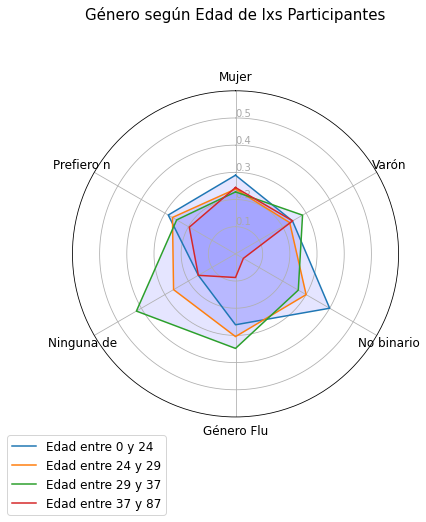

In [ ]:
radar_plot(genero_segun_edad, title = 'Género según Edad de lxs Participantes')

Más allá de lo que significa esto, vemos que es posible utilizar los radar plots para analizar distribuciones/proporciones, diferenciando según categorías

## Imshow


Imshow es un método de matplotlib.pylab para poder graficar matrices.

Veamos cuál es la taza de cambio media en la percepción de la efectividad de las vacunas, según si a lxs participantes se les habló de una u otra vacuna, desde una u otra narrativa.


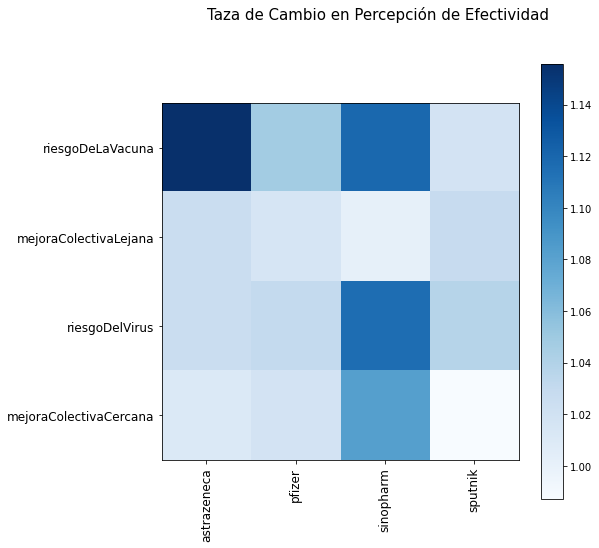

In [ ]:
d_taza_de_cambio = d_1[(d_1['0_forkNarrativa'] != '-999') & (d_1['0_forkVacuna'] != '-999')][['0_forkNarrativa', '0_forkVacuna','0_preEfectiva', '0_postEfectiva']].copy() # Seleccionamos columnas y nos quedamos con las filas que no tengan los -999
d_taza_de_cambio['taza de cambio'] = d_taza_de_cambio['0_postEfectiva'] / d_taza_de_cambio['0_preEfectiva']
d_taza_de_cambio = d_taza_de_cambio.groupby(['0_forkNarrativa', '0_forkVacuna'])['taza de cambio'].apply(lambda x : np.ma.masked_invalid(x).mean()).unstack(1) # Usamos esta función, porque alguno de los registros pasan a valer inf después de tomar el cociente
d_taza_de_cambio = d_taza_de_cambio.sort_values(by = d_taza_de_cambio.columns.to_list(), ascending = False) # Este ordenamiento hace que mínimamente la matriz vaya a quedar mejor ordenada para la visualización

fig, ax = plt.subplots(figsize = (8,8))

im = ax.imshow(d_taza_de_cambio.values, cmap = 'Blues')

ax.set_yticks(range(len(d_taza_de_cambio)))
ax.set_yticklabels(d_taza_de_cambio.index, fontsize = 12)

ax.set_xticks(range(len(d_taza_de_cambio.keys())))
ax.set_xticklabels(d_taza_de_cambio.columns, fontsize = 12, rotation = 90)

fig.suptitle('Taza de Cambio en Percepción de Efectividad', fontsize = 15)

fig.colorbar(im, orientation = 'vertical')

plt.show()

## Wordclouds



Las nubes de palabras pueden ser una herramienta interesante para visualizar palabras o expresiones, donde el tamaño aparece según su frecuencia de aparición.

Veamos un ejemplo

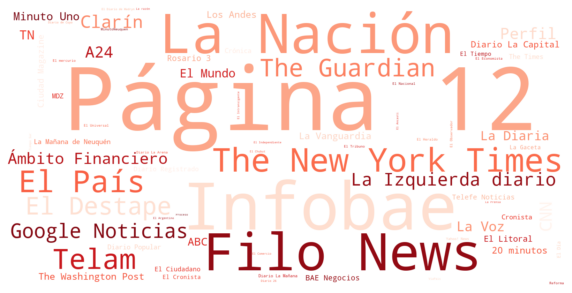

In [ ]:
d_diarios_consumidos = d_1[(d_1['0_diarios'].str.contains('[^0-9]+') == False) & (d_1['0_diarios'] != '-999')][['0_diarios','hash']] # Nos quedamos con aquellas filas que contengan las opciones pre-establecidas (nos ahorramos el tema de texto libre)
d_diarios_consumidos['0_diarios'] = d_diarios_consumidos['0_diarios'].astype(int) # Lo llevamos a entero por una compatibilidad

diarios_file = '/content/drive/My Drive/Clase 9_04_21/Diccionario Vacunas - Diarios.csv'

d_diarios = pd.read_csv(diarios_file)

d = d_diarios_consumidos.merge(d_diarios, how = 'inner', right_on = 'ID', left_on = '0_diarios')['Opción']

wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               colormap = 'Reds' # La gama de colores para coloreal
               ).generate_from_frequencies(d.value_counts().to_dict())
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()

# Pandas


Si bien ya vimos que Pandas es una excelente librería para manejar datos, y realizar operaciones sobre los mismos, también está integrada con matplotlib y permite rápidamente generar visualizaciones.

Tanto las series como los data frames tendrán métodos .plot() que podremos llamar con la siguiente sintaxis:



```
pd.Series.plot()
# o
pd.DataFrame.plot()
```
donde dentro de otras cosas, podremos indicar cuáles columnas queremos graficar, o por cual columna queremos categorizar los datos. Algo muy importante resulta ser el argumento "ax", con el cual podemos indicarle sobre qué eje queremos que realice el gráfico, y ahí podemos integrarlo directamente con la sintaxis previamente vista de matplotlib, lo que puede darnos más manejo de la estética del gráfico.

Veamos por ejemplo, lo fácil que es estudiar cómo fue respondida la encuesta en términos temporales (una pavada, pero esto puede ayudar a dar cuenta si en algún momento falló la página, o bien si una campaña de difusión tuvo efecto, perdón, mucho marketig digital). Para esto, tenemos que agrupar los datos según un intervalo temporal determinado (una frecuencia) y contar la cantidad de respuestas a la encuesta en dicho intervalo.

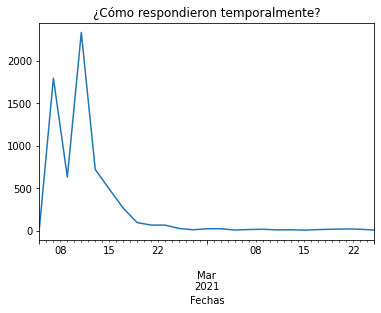

In [ ]:
d_1.groupby(pd.Grouper(key = 'timestamp',
                       freq = '2d') # Guarden esta funcioncita porque es clave para agrupar fechas como se les plazca
            ).hash.count().plot(kind = 'line', # por default
                                #ax = algun eje,
                                title = '¿Cómo respondieron temporalmente?',
                                xlabel = 'Fechas',
                                )

plt.show()

Ahora bien, por ejemplo, vemos que el temita de las fechas resulta medio arbitrario. Si queremos customizar de una forma más controlada las etiquetas, podemos integrar pandas con la sintaxis de matplotlib previamente vista

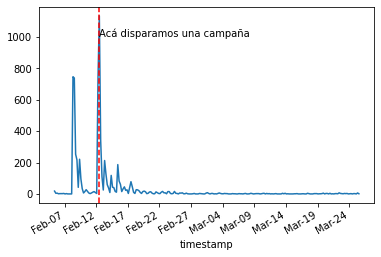

In [ ]:
actividad_temporal = d_1.groupby(pd.Grouper(key = 'timestamp',
                                            freq = '5h') # Guarden esta funcioncita porque es clave para agrupar fechas como se les plazca
                                 ).hash.count()
fig, ax = plt.subplots()
actividad_temporal.plot(kind = 'line', # por default
                        #title = '¿Cómo respondieron temporalmente?',
                        #xlabel = 'Fechas',
                        ax = ax,
                        x_compat = True # Esto parece importante, matplotlib trabaja distinto que pandas el tema de fechas y esto parece acomodar todo
                        )
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d',))
plt.gcf().autofmt_xdate()
ax.axvline(actividad_temporal.sort_values().keys()[-1],
           linestyle = 'dashed',
           color = 'red')
ax.text(x = actividad_temporal.sort_values().keys()[-1],
        y = 1000,
        s = 'Acá disparamos una campaña')
plt.show()

# Seaborn


En el camino de integración que estamos siguiendo, pareciera que seaborn es la librería final (?).

Trabaja integrando la estructura de data frames de pandas, junto con matplotlib, permitiendo customizaciones y gráficos muy particualres. También, permite setear estilos, lo que puede ser muy útil en distitos contextos

Usemos los siguientes datos: veamos cómo es la evaluación del gobierno, según rango etario de lxs participantes.

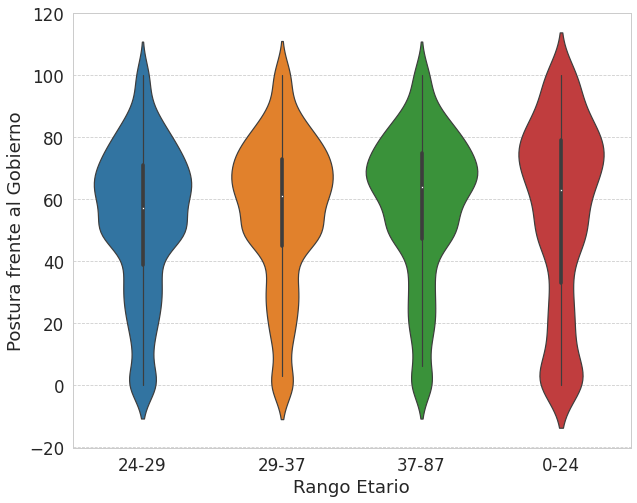

In [ ]:
sbn.set_context("paper", font_scale = 1.9,) # Existen otros contextos, lo relevante me parece el font_scale, que nos permite desprendernos de setear tamaños estáticos
sbn.set_style("whitegrid",rc = {'grid.linestyle': '--'})

fig, ax = plt.subplots(figsize = (10,8)) # Medio que esta línea la vamos a necesitar casi siempre

sbn.violinplot(data = d_1,
               x = pd.qcut(d_1['0_edad'],
                           q = 4),
               y = '0_posturaGobierno') # Pero lo jugoso está acá, en una línea, esto nos ahorró el laburo de agrupar y etc
ax.set_xlabel('Rango Etario')
ax.set_ylabel('Postura frente al Gobierno')
ax.set_xticklabels(['{}-{}'.format(int(i.left), int(i.right)) for i in pd.qcut(d_1['0_edad'], q = 4).unique()])
plt.show()

Indaguen en seaborn, tiene una banda de opciones. 

Por ejemplo, podemos estudiar problemas x vs y y ver cómo son las distribuciones x e y




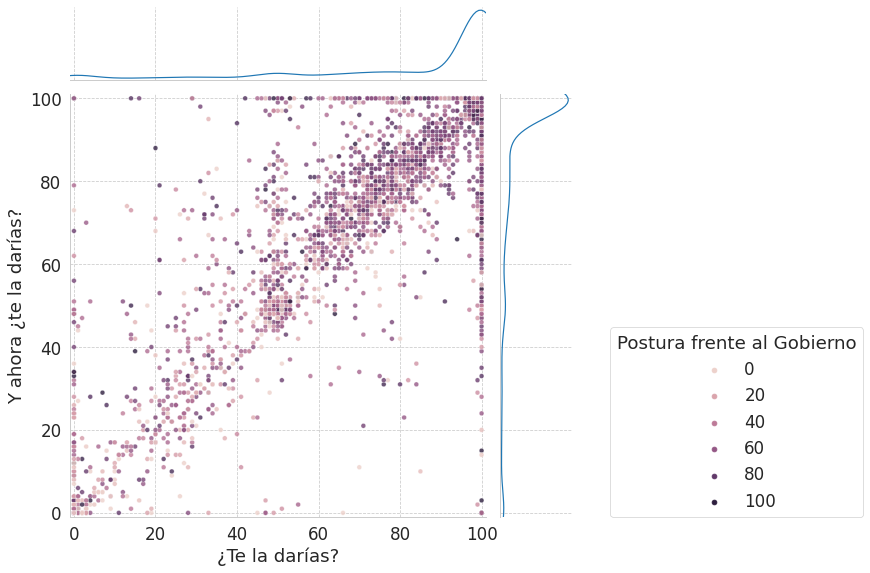

In [ ]:
sbn.set_context("paper", font_scale = 1.9,) # Existen otros contextos, lo relevante me parece el font_scale, que nos permite desprendernos de setear tamaños estáticos
sbn.set_style("whitegrid",rc = {'grid.linestyle': '--'})

grid = sbn.JointGrid(data = d_1, height = 8)
ax = sbn.scatterplot(data = d_1[(d_1['0_preTeDarias'] != -999) & (d_1['0_postTeDarias'] != -999)], # Definimos la base de datos a trabajar
                x = '0_preTeDarias', # Definimos el campo a plotear en el eje x
                y = '0_postTeDarias',# Definimos el campo a plotear en el eje y
                ax = grid.ax_joint, # Definimos el eje al cual se le adjunta el gráfico
                hue = '0_posturaGobierno', # hue : es el campo que determina el color (puede ser númerico o categórico)
                alpha = 0.8 # La transparencia de los puntos
                )
sbn.kdeplot(d_1[(d_1['0_preTeDarias'] != -999) & (d_1['0_postTeDarias'] != -999)]['0_preTeDarias'], ax = grid.ax_marg_x)
sbn.kdeplot(y = d_1[(d_1['0_preTeDarias'] != -999) & (d_1['0_postTeDarias'] != -999)]['0_postTeDarias'], ax = grid.ax_marg_y)
ax.set_xlabel('¿Te la darías?')
ax.set_ylabel('Y ahora ¿te la darías?')
ax.legend(loc = (1.3,0), title = 'Postura frente al Gobierno')
ax.axis([-1,101, -1, 101])
plt.show()

sbn.reset_orig() # Usamos esta línea para resetear la configuración de ploteo. Permite que, en las siguientes celdas, creemos figuras con la configuración standar de matplotlib

# Widgets


Los widgets son elementos de UI (user interaction...). Entiendo que el paquete ipywidgets permite generar estos elementos, sin necesidad de meterse a programar en Java Script (destino final de toda persona que quiera diseñar realmente).

La idea general va a ser: armar una función cuya entrada serán parámetros dinámicos. Cada vez que modifiquemos un parámetro a partir de los widgets, esta función será ejecutada. En esta notebook, nuestras funciones involucrarán la generación de figuras.

Sin ánimo de aburrir, volvamos a hacer el gráfico temporal, pero ahora pudiendo seleccionar un rango de fechas determinado

In [ ]:
rango_fechas = pd.date_range(d_1['timestamp'].min(), d_1['timestamp'].max(), freq='D') # Armamos una línea de tiempo, espaciada de a un día
opciones = [(fecha.strftime('%d/%m/%y'), fecha) for fecha in rango_fechas] # Generamos una lista para determinar cómo elegimos nuestras opciones
index = (0, len(opciones)-1)
w_f = widgets.SelectionRangeSlider(options = opciones, # Acá, damos forma a la barra para fechas
                                   index = index,
                                   description = 'Fechas',
                                   orientation ='horizontal',
                                   layout = {'width': '600px'},
                                   continuous_update = False)
# Listo, ya tenmos nuestro widget, que se visualiza así:
w_f

SelectionRangeSlider(continuous_update=False, description='Fechas', index=(0, 48), layout=Layout(width='600px'…

In [ ]:
# Definamos ahora la función que grafique los datos, según los parámetros de fecha
def grafico_en_funcion_del_tiempo(df, fecha):
    d = df.copy()
    d = d[d['timestamp'].between(*fecha)]
    actividad_temporal = d.groupby(pd.Grouper(key = 'timestamp',
                                              freq = '5h') # Guarden esta funcioncita porque es clave para agrupar fechas como se les plazca
                                   ).hash.count()
    fig, ax = plt.subplots(figsize = (15,7))
    actividad_temporal.plot(kind = 'line', # por default
                            ax = ax,
                            title = '¿Cómo respondieron temporalmente?',
                            xlabel = 'Fechas',
                            x_compat = True # Esto parece importante, matplotlib trabaja distinto que pandas el tema de fechas y esto parece acomodar todo
                            )
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d',))
    plt.gcf().autofmt_xdate()
    ax.axvline(actividad_temporal.sort_values().keys()[-1],
              linestyle = 'dashed',
              color = 'red')
    ax.text(x = actividad_temporal.sort_values().keys()[-1],
            y = actividad_temporal.max(),
            s = 'Acá disparamos una campaña')
    plt.show()

plot_interactivo = interact(grafico_en_funcion_del_tiempo, df = fixed(d_1), fecha = w_f)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Fechas', index=(0, 48), layou…

# Poltly (dash - plotly)

Plotly, junto con dash, es una librería de python que nos permite generar visualizaciones en un html, la cual de por sí es interactiva.

Puede ser muy útil para el armado de tableros o aplicaciones dinámicas (que integradas con servidores remotos tipo pythonanywhere) que nos permiten comunicar nuestros resultados o análisis con gente que no necesariamente sepa de python. Es decir, nos da una herramienta interactiva sin necesidad de que nadie tenga que correr nada.

Repitamos lo previo, pero veamos qué sencillo se vuelve:


In [ ]:
actividad_temporal = d_1.groupby(pd.Grouper(key = 'timestamp',
                                            freq = '1h'),
                                  ).hash.count().reset_index().rename({'hash':'Cantidad de Respuestas','timestamp' : 'Fecha'}, axis = 1)
grafico = px.line(data_frame = actividad_temporal,
                  x = 'Fecha',
                  y = 'Cantidad de Respuestas',
                  )
grafico.update_traces(hovertemplate = '%{x|%a %d de %b de %Y }<br>Cantidad de Respuestas: %{y}') # Modificamos la forma en la que nos muestra las fechas en el on-hover

In [ ]:
from google.colab import files # Lo traigo para poder llevarnos el gráfico
grafico.write_html('grafico.html')
files.download('grafico.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d_1['0_paisResidencia'].value_counts()

11     6331
63      101
236      94
2        24
140      19
40       16
64       16
14        9
44        8
30        7
177       7
178       6
70        5
58        5
184       5
54        4
215       4
121       4
96        3
120       3
239       3
38        3
27        3
81        2
214       2
12        2
180       2
148       1
68        1
56        1
48        1
181       1
13        1
53        1
169       1
62        1
118       1
182       1
186       1
51        1
175       1
187       1
8         1
Name: 0_paisResidencia, dtype: int64